In [2]:
import scipy as sp
import scipy.optimize as op
import numpy as np
import pylab as pl
import emcee
from scipy.special import erfc
from lmfit.models import SkewedGaussianModel
%matplotlib inline

In [46]:
filename = 'run562.txt'
infile = open(filename,'r')

xvals2=[];ymeas2=[]
while True:
    line = infile.readline()
    if not line: break
        
    items = line.split()
    xvals2.append(float(items[0]))
    ymeas2.append(float(items[1]))
    
xvals = np.array(xvals2[1800:2000])
ymeas = np.array(ymeas2[1800:2000])

infile.close()

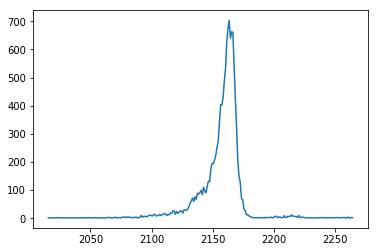

In [47]:
pl.subplot(111)
pl.plot(xvals,ymeas)
pl.show()

---

https://lmfit.github.io/lmfit-py/builtin_models.html#skewedgaussianmodel

In [48]:
'''
def gauss_fn(p0, x):
    
    amp,mu,sigma,gamma = p0
    model = SkewedGaussianModel()
        #amp*=sigma*np.sqrt(2*np.pi)
    
    # set initial parameter values
    params = model.make_params(amplitude=amp, center=mu, sigma=sigma, gamma=gamma)
    ymod = model.eval(params=params,x=x)
    
    return ymod
'''

def gf3(p0, x):
    #this is the fuctional form that we have been using in our manual fit
    #it is the sum of a gaussian and a skewed gaussian with the same mean
    #the extra parameters r and beta are introduced
    #r is the fraction of the height of the skewed gaussian given as a pecentage
    #beta is the 'skewneess' of the second skew gaussian
    #it is the decay constant of an exponential tail on the skewed gaussian
    #this exponential tail is convolved with a gaussian resolution function
    
    amp, mu, sigma, r, beta = p0
    
    #gaussian part
    ygaus = amp * (1 - r/100) * np.exp((-(x - mu)**2)/(2 * sigma**2))
    
    #'skew' gaussian part. erfc is 1 - the error function
    yskew = amp * (r/100) * np.exp((x-mu)/beta) * erfc( (x-mu)/(sigma * np.sqrt(2))  + sigma/(beta*np.sqrt(2)))
    #yskew = 0
    #ygaus = 0
    ymod = yskew + ygaus
    
    return ymod

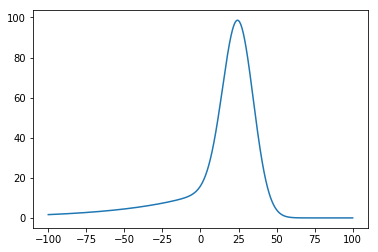

In [49]:
#test to see if this function looks correct
x = np.arange(-100, 100, step = 0.001)
y = gf3([100, 25, 10, 10,50],x)

#y = np.exp(((x-5)/5)) * erfc(((x-5)/(10*2**0.5)) + 2/(5*2**0.5 ))
pl.plot(x,y)

pl.show()

In [50]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    #ymod = gauss_fn(p0,x)
    ymod = gf3(p0,x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [51]:
# use maxvalue to guess amplitude:
a0 = np.max(ymeas)

# use position of maxvalue to guess mean:
m0 = xvals[np.argmax(ymeas)]

# just guess width:
s0 = 10.

# just guess r and beta from what they usually turn out about from experience
r0 = 10.
b0 = 5.

# adjust the amplitude for the normalisation factor:
#a0*=s0*np.sqrt(2*np.pi)

print(a0,m0,s0,r0,b0)
p0 = np.array([a0,m0,s0,r0,b0])

704.0 2163.5 10.0 10.0 5.0


In [52]:
bnds = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))

print(len(p0))
print(len(bnds))

5
5


In [53]:
nll = lambda *args: -lnlike(*args)

result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

In [54]:
print(p1)

[ 717.00898068 2164.43769642    4.71246332   29.54070326   15.49040933]


-309.9316640252073


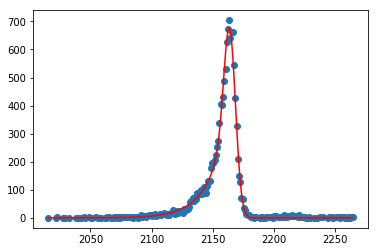

In [55]:
yfit = gf3(p1,xvals)

fig = pl.figure(1)

ax = fig.add_subplot(111)

ax.scatter(xvals,ymeas)
ax.plot(xvals,yfit,c='r')

fig.savefig("gf3fit.png")

print(lnlike(p1, xvals, ymeas))

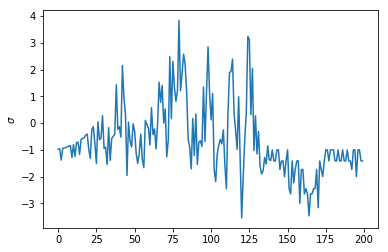

In [56]:
res = (yfit - ymeas)/np.sqrt(ymeas)
fig = pl.figure(1)
ax = fig.add_subplot(111)
pl.plot(res)
pl.ylabel(r"$\sigma$")
fig.savefig("residuals.png")

These residuals still look weird.

---

In [57]:
ndim, nwalkers = 5, 500
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

In [58]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(xvals, ymeas))

In [59]:
p0 = sampler.run_mcmc(pos, 100) #this doesn't work with 500 as it tries to use a negative value of r

In [60]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))
print(samples.shape)

(25000, 5)


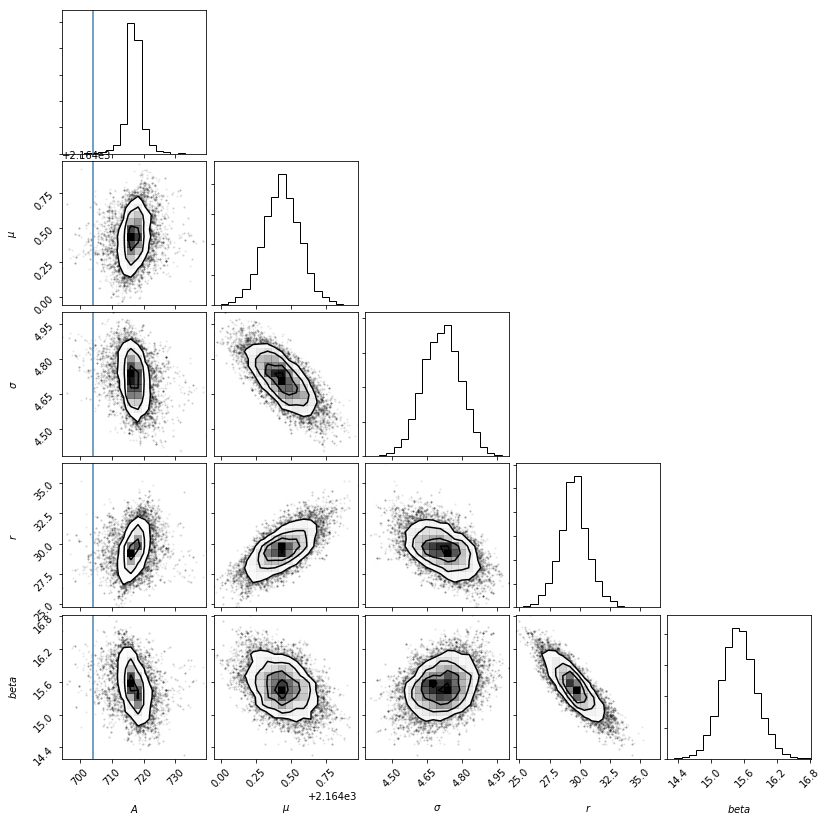

In [61]:
import corner

fig = corner.corner(samples, labels=["$A$", "$\mu$", "$\sigma$","$r$", "$beta$"],
                      truths=[a0, m0, s0, r0, b0])
fig.savefig("triangle.png")

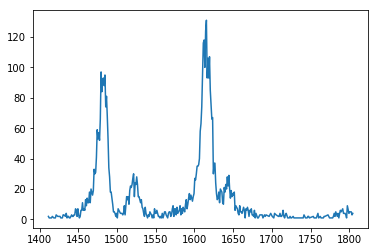

In [67]:
#now do it with a multiplet
xvals = np.array(xvals2[1300:1650])
ymeas = np.array(ymeas2[1300:1650])

pl.plot(xvals,ymeas)
pl.show()

In [91]:
def lnlike(p0, x, y):
    
    # get model for these parameters:
    npeaks = int(len(p0)/5)
    ymod = 0
    for i in range(npeaks):
        ymod += gf3(p0[i*5:(i+1)*5],x)
    
    # Poisson loglikelihood:
    ll = np.sum(ymod[np.where(ymeas!=0)]*np.log(ymeas[np.where(ymeas!=0)])) - np.sum(ymeas) - np.sum(ymod[np.where(ymod!=0)]*np.log(ymod[np.where(ymod!=0)]) - ymod[np.where(ymod!=0)])
    
    return ll

In [126]:
bnds1 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))
bnds2 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))
bnds3 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))
bnds4 = ((None,None), (None,None), (0.1,None), (0.1, 100), (0.1,None))

bnds = []

for peak in [bnds1,bnds2,bnds3,bnds4]:
    for bound in peak:
        bnds.append(bound)

        
bnds
#len(p0) == len(bnds)



[(None, None),
 (None, None),
 (0.1, None),
 (0.1, 100),
 (0.1, None),
 (None, None),
 (None, None),
 (0.1, None),
 (0.1, 100),
 (0.1, None),
 (None, None),
 (None, None),
 (0.1, None),
 (0.1, 100),
 (0.1, None),
 (None, None),
 (None, None),
 (0.1, 7),
 (0.1, 100),
 (0.1, None)]

In [127]:
A1 = 100
mu1 = 1470
sig1 = 4
r1 = 30
b1 = 15

A2 = 40
mu2 = 1520
sig2 = 4
r2 = 30
b2 = 15

A3 = 100
mu3 = 1620
sig3 = 4
r3 = 30
b3 = 15

A4 = 40
mu4 = 1650
sig4 = 4
r4 = 30
b4 = 15

g1 = [A1,mu1,sig1,r1,b1]
g2 = [A2,mu2,sig2,r2,b2]
g3 = [A3,mu3,sig3,r3,b3]
g4 = [A4,mu4,sig4,r4,b4]

p0 = []

for peak in [g1,g2,g3,g4]:
    for parameter in peak:
        p0.append(parameter)



len(p0)

20

In [128]:
result = op.minimize(nll, p0, bounds=bnds, args=(xvals, ymeas))
p1 = result["x"]

[ 115.7022538  1484.59064192    4.4506757    61.18356573    8.04725424]
[  23.55270542 1522.41935794    6.23221894    5.55574805  127.42702339]
[ 134.60358912 1616.31119836    5.44689547   38.31967272    7.72860902]
[  11.3858804  1656.74048551    7.           99.99203087   47.62269525]


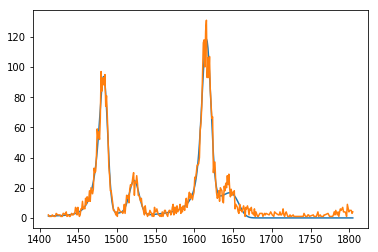

In [129]:
#print(p1)

npeaks = int(len(p1)/5)
ymod = 0
for i in range(npeaks):
    print(p1[i*5:(i+1)*5])
    ymod += gf3(p1[i*5:(i+1)*5],xvals)
    
#thing = 
pl.plot(xvals, ymod)
pl.plot(xvals,ymeas)
pl.show()


In [ ]:
#this is why we fix the relative widths